# EE4675 Object Classification with Radar Project

Object classification project for the TU Delft course EE4675 Object classification with radar

Written by:
- Adnane Acudad 5565499
- Peter de Bruin 5341353
- Joost Jaspers 5372925

# File Purpose
This notebook demonstrates key pre-processing steps for radar-based human activity classification, including:
- I/Q signal correction and DC offset removal
- Range-Time processing and MTI filtering
- Spectrogram generation for micro-Doppler analysis
- Torso detection and removal
- Limb motion envelope extraction
- Extracting plots for the final presentation

The techniques shown here form the foundation for our feature extraction pipeline used in activity classification.

### Imports and initializations:

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import os
import tkinter as tk
from tkinter import filedialog

# Hide the root Tk window
root = tk.Tk()
root.withdraw()

# # Define the relative path to the dataset file
relative_path = 'datasets/1 December 2017 Dataset/3P36A03R01.dat'

# # Get absolute full path based on current working directory (i.e., location of notebook)
fullpath = os.path.join(os.getcwd(), relative_path)


### Data Reading and extracting the parameters

In [41]:
def datareader(path):# Check if the file exists
    """Reads radar data from a file and extracts parameters."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Could not find file at: {path}")

    # Read the data from the file as text, replace 'i' with 'j', and convert to complex
    with open(path, 'r') as f:
        lines = f.readlines()

    # Convert header (first 4 lines) to float
    header = [float(lines[i].strip()) for i in range(4)]

    # Convert the rest to complex numbers
    data_strs = [line.strip().replace('i', 'j') for line in lines[4:]]
    data_complex = np.array([complex(s) for s in data_strs])

    # Combine header and data for compatibility with the rest of the code
    radarData = np.array(header + list(data_complex))

    # Extract parameters
    fc = radarData[0]  # Center frequency in Hz
    Tsweep = radarData[1] / 1000  # Sweep time in seconds (converted from ms)
    NTS = int(radarData[2])  # Number of time samples per sweep
    Bw = radarData[3]  # Bandwidth in Hz
    Data = radarData[4:]  # Raw radar data

    # Calculate sampling parameters
    fs = NTS / Tsweep  # Sampling frequency
    nc = int(len(Data) / NTS)  # Number of chirps

    return fc, Tsweep, NTS, Bw, fs, nc, Data

# Read the data from the file
fc, Tsweep, NTS, Bw, fs, nc, Data = datareader(fullpath)
print(f"fc: {fc}, Tsweep: {Tsweep}, NTS: {NTS}, Bw: {Bw}, fs: {fs}, nc: {nc}")

fc: (5800000000+0j), Tsweep: (0.001+0j), NTS: 128, Bw: (400000000+0j), fs: (128000+0j), nc: 10000


C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\3460976899.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  NTS = int(radarData[2])  # Number of time samples per sweep


### Perform I/Q correction to remove dc offset and correct phase

c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


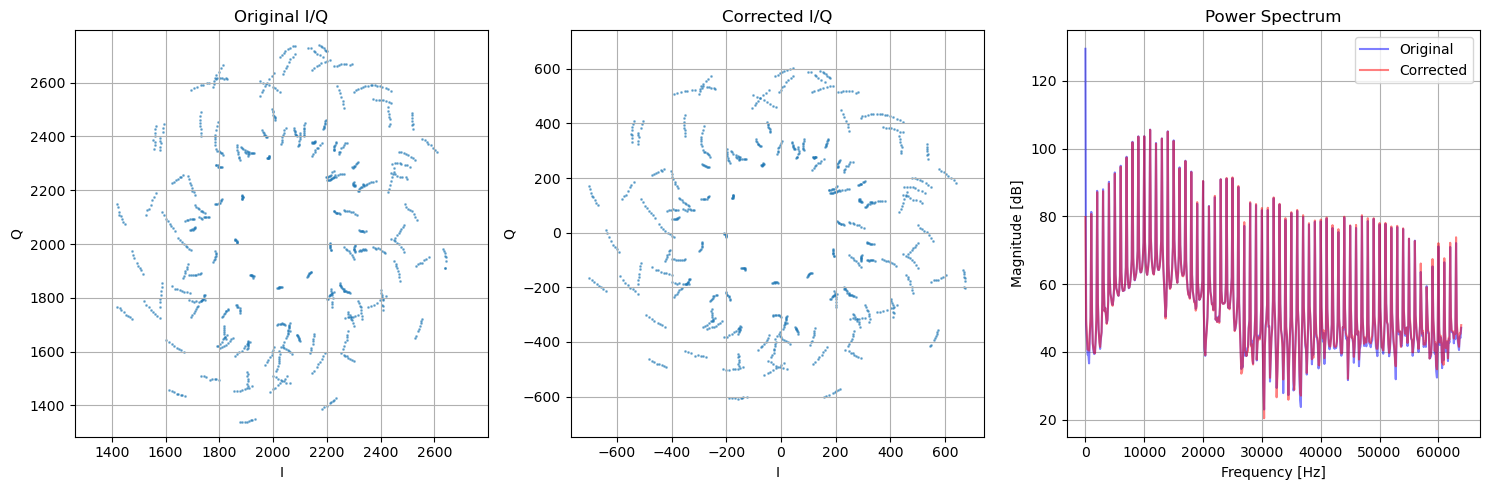

In [42]:
def MTI_filter(Data_range, cutoff=0.0075):
    """
    Apply a Moving Target Indication (MTI) filter to the range data.
    
    Parameters:
    Data_range : 2D array
        Range data to be filtered.
    
    Returns:
    Data_range_MTI : 2D array
        Filtered range data.
    """
    # Design a 4th-order high-pass Butterworth filter
    b, a = signal.butter(4, cutoff, 'high')
    # Apply filter to each range bin across chirps
    Data_range_MTI = np.zeros_like(Data_range, dtype=complex)
    for k in range(Data_range.shape[0]):
        Data_range_MTI[k, :] = signal.lfilter(b, a, Data_range[k, :])
    # Remove the first range bin
    Data_range_MTI = Data_range_MTI[1:, :]

    return Data_range_MTI

def iq_correction(raw_data):
    """
    Perform I/Q correction on complex radar data
    
    Args:
        raw_data (np.ndarray): Complex IQ data
        window_size (int): Window size for moving average
        
    Returns:
        np.ndarray: Corrected complex IQ data
    """
    # Split into I and Q components
    i_data = np.real(raw_data)
    q_data = np.imag(raw_data)
    
    # DC offset removal
    i_dc = np.mean(i_data)
    q_dc = np.mean(q_data)
    i_data = i_data - i_dc
    q_data = q_data - q_dc
    
    # Amplitude correction
    i_amp = np.sqrt(np.mean(i_data**2))
    q_amp = np.sqrt(np.mean(q_data**2))
    amp_correction = np.sqrt(i_amp * q_amp)
    i_data = i_data * (amp_correction / i_amp)
    q_data = q_data * (amp_correction / q_amp)
    
    # Phase imbalance correction
    iq_corr = np.mean(i_data * q_data)
    phase_error = np.arcsin(iq_corr / (i_amp * q_amp))
    q_data_corr = q_data * np.cos(phase_error) - i_data * np.sin(phase_error)
    
    return i_data + 1j * q_data_corr

# Store original data before I/Q correction
Data_original = Data.copy()

# Apply I/Q correction
Data_corrected = iq_correction(Data)

# Compare original vs corrected data
plt.figure(figsize=(15, 5))

# Plot 1: Original I/Q scatter plot
plt.subplot(131)
plt.scatter(np.real(Data_original[:1000]), np.imag(Data_original[:1000]), 
           alpha=0.5, s=1, label='Original')
plt.axis('equal')
plt.title('Original I/Q')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)

# Plot 2: Corrected I/Q scatter plot
plt.subplot(132)
plt.scatter(np.real(Data_corrected[:1000]), np.imag(Data_corrected[:1000]), 
           alpha=0.5, s=1, label='Corrected')
plt.axis('equal')
plt.title('Corrected I/Q')
plt.xlabel('I')
plt.ylabel('Q')
plt.grid(True)

# Plot 3: Power spectrum comparison
plt.subplot(133)
f_orig = np.abs(np.fft.fft(Data_original[:1024]))
f_corr = np.abs(np.fft.fft(Data_corrected[:1024]))
freq = np.fft.fftfreq(1024, d=1/fs)
plt.plot(freq[:512], 20*np.log10(f_orig[:512]), 'b-', alpha=0.5, label='Original')
plt.plot(freq[:512], 20*np.log10(f_corr[:512]), 'r-', alpha=0.5, label='Corrected')
plt.title('Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




### Reshape data into chirps and plot range-time

Data_time shape: (128, 10000)
Data_range shape: (64, 10000)


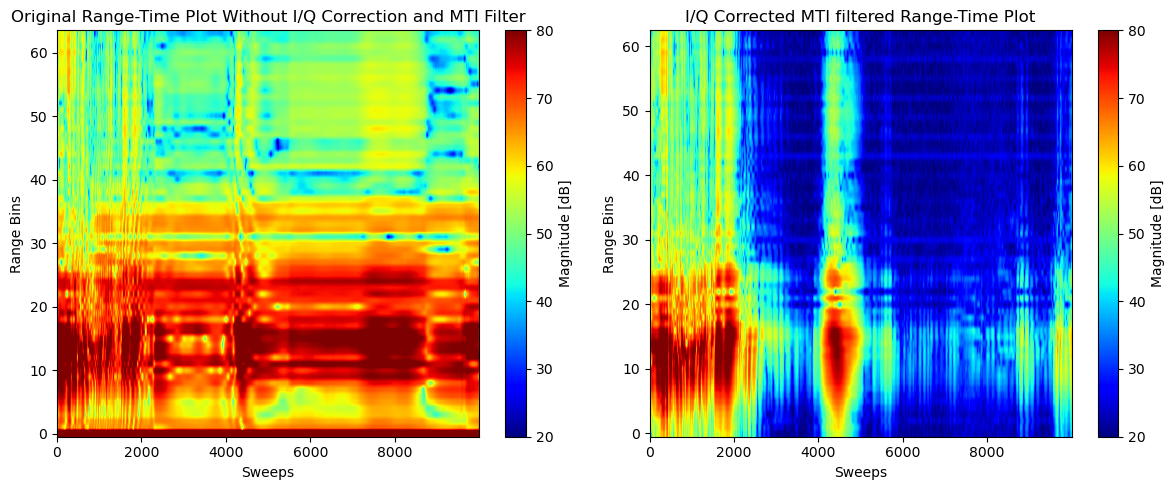

In [43]:
# Reshape data into [NTS, nc] array
Data_time = Data.reshape((NTS, nc), order='F') 
Data_time_orig = Data_original.reshape((NTS, nc), order='F')

print(f"Data_time shape: {Data_time.shape}")

# Apply a rectangular window
win = np.ones((NTS, nc))

# Compute FFT and shift zero-frequency component to center
tmp = np.fft.fftshift(np.fft.fft(Data_time * win, axis=0), axes=0)
tmp_orig = np.fft.fftshift(np.fft.fft(Data_time_orig * win, axis=0), axes=0)


Data_range = tmp[NTS//2:, :]  # Take positive frequency components
Data_range_orig = tmp_orig[NTS//2:, :]
print(f"Data_range shape: {Data_range.shape}")

# Number of sweeps to process (assuming ns = nc)
ns = nc

# Apply MTI filter to the range data
Data_range_MTI_orig = MTI_filter(Data_range_orig, cutoff=0.0075)
Data_range_MTI = MTI_filter(Data_range, cutoff=0.0075)

# Also compare spectrograms
plt.figure(figsize=(12, 5))

# Calculate global color limits from both datasets
data1 = 20 * np.log10(np.abs(Data_range_orig))
data2 = 20 * np.log10(np.abs(Data_range_MTI))
vmax = 80
vmin = vmax - 60  # 60 dB dynamic range

# Original spectrogram
plt.subplot(121)
im1 = plt.imshow(data1, aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
plt.title('Original Range-Time Plot Without I/Q Correction and MTI Filter')
plt.xlabel('Sweeps')
plt.ylabel('Range Bins')
plt.colorbar(label='Magnitude [dB]')

# Corrected spectrogram
plt.subplot(122)
im2 = plt.imshow(data2, aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
plt.title('I/Q Corrected MTI filtered Range-Time Plot')
plt.xlabel('Sweeps')
plt.ylabel('Range Bins')
plt.colorbar(label='Magnitude [dB]')

plt.tight_layout()
plt.show()

# Continue with the rest of your processing using Data_corrected
Data = Data_corrected

### Spectrogram processing for 2nd FFT to get Doppler

In [44]:
def kalman_filter_1d(observed, dt, process_noise, measurement_noise):
    A = np.array([[1, dt], [0, 1]])
    B = np.array([[0.5 * dt**2], [dt]])
    C = np.array([[1, 0]])
    Q = process_noise * np.array([[dt**4/4, dt**3/2], [dt**3/2, dt**2]])
    R = measurement_noise ** 2

    x = np.array([[observed[0]], [0]])  # initial state: position + velocity
    P = np.eye(2)
    filtered = []

    for z in observed:
        # Predict
        x = A @ x
        P = A @ P @ A.T + Q

        # Update
        K = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
        x = x + K @ (z - C @ x)
        P = (np.eye(2) - K @ C) @ P

        filtered.append(x[0, 0])
    
    return np.array(filtered)

def remove_torso_from_spectrogram(Sxx, velocity_axis, torso_velocity_trace, bandwidth=0.4):
    """
    Removes the torso signature from the spectrogram by:
    1. Shifting torso velocity to zero
    2. Zeroing out a band ±bandwidth [m/s] around 0 velocity
    3. Shifting back to original position
    """
    Sxx_torso_removed = np.zeros_like(Sxx)
    zero_idx = np.argmin(np.abs(velocity_axis - 0))

    for i, torso_vel in enumerate(torso_velocity_trace):
        # Shift to center torso at 0
        shift_idx = np.argmin(np.abs(velocity_axis - torso_vel))
        shift_amount = zero_idx - shift_idx
        shifted_col = np.roll(Sxx[:, i], shift=shift_amount)

        # Apply suppression mask around 0 velocity
        suppress_mask = np.abs(velocity_axis) <= bandwidth
        shifted_col[suppress_mask] = 0

        # Shift back to original position
        Sxx_torso_removed[:, i] = np.roll(shifted_col, shift=-shift_amount)

    return Sxx_torso_removed

def detect_envelope(Sxx_dB, velocity_axis, threshold_dB):
    n_bins, n_frames = Sxx_dB.shape
    upper_envelope = np.full(n_frames, np.nan)
    lower_envelope = np.full(n_frames, np.nan)

    for i in range(n_frames):
        above_thresh = np.where(Sxx_dB[:, i] > threshold_dB)[0]
        if len(above_thresh) > 0:
            lower_envelope[i] = velocity_axis[above_thresh[0]]
            upper_envelope[i] = velocity_axis[above_thresh[-1]]

    return lower_envelope, upper_envelope

C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\822859030.py:14: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Sxx = signal.spectrogram(Data_range_MTI[RBin, :], fs=PRF, window='hann',
c:\Users\Joost\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1947: ComplexWarning: Casting complex values to real discards the imaginary part
  nperseg - noverlap)/float(fs)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


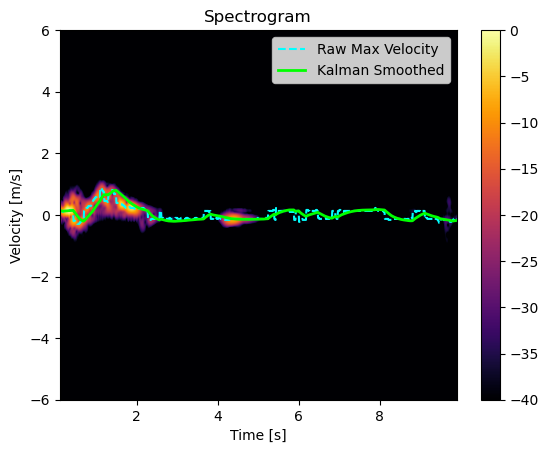

In [45]:
# Spectrogram parameters for Doppler processing
bin_indl = 10 - 1  # Adjust for 0-based indexing
bin_indu = 30 - 1  # Adjust for 0-based indexing
PRF = 1 / Tsweep  # Pulse repetition frequency
TimeWindowLength = 200
OverlapFactor = 0.95
OverlapLength = int(np.round(TimeWindowLength * OverlapFactor))
Pad_Factor = 4
FFTPoints = Pad_Factor * TimeWindowLength

# Compute spectrogram for selected range bins and sum magnitudes
Data_spec_MTI2 = None
for RBin in range(bin_indl, bin_indu + 1):
    f, t, Sxx = signal.spectrogram(Data_range_MTI[RBin, :], fs=PRF, window='hann',
                                   nperseg=TimeWindowLength, noverlap=OverlapLength,
                                   nfft=FFTPoints, mode='complex')
    Sxx_shifted = np.fft.fftshift(Sxx, axes=0)
    if Data_spec_MTI2 is None:
        Data_spec_MTI2 = np.abs(Sxx_shifted)
    else:
        Data_spec_MTI2 += np.abs(Sxx_shifted)

# Normalize the spectrogram
Data_spec_MTI2 /= np.max(Data_spec_MTI2)

# Compute Doppler and velocity axes
DopplerAxis = np.fft.fftshift(np.fft.fftfreq(FFTPoints, d=1 / PRF))
velocity_axis = DopplerAxis * 3e8 / (2 * fc)  # Convert Doppler frequency to velocity

# Find the torso
# Take max Doppler bin per time frame
raw_indices = np.argmax(Data_spec_MTI2, axis=0)
raw_torso_velocity = velocity_axis[raw_indices]  # Shape: (len(t),)

dt = 1 / PRF  # time step between spectrogram frames
kalman_torso_velocity = kalman_filter_1d(raw_torso_velocity, dt, process_noise=10000.0, measurement_noise=0.1)


# Plot Spectrogram
plt.figure()
im = plt.imshow(20 * np.log10(Data_spec_MTI2), aspect='auto', origin='lower',
                extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]], cmap='inferno')
plt.plot(t, raw_torso_velocity, color='cyan', linestyle='--', linewidth=1.5, label='Raw Max Velocity')
plt.plot(t, kalman_torso_velocity, color='lime', linestyle='-', linewidth=2, label='Kalman Smoothed')
plt.legend()
plt.ylim(-6, 6)  # Limit velocity axis
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Spectrogram')
clim = im.get_clim()
plt.clim(clim[1] - 40, clim[1])  # Set color limits
plt.colorbar()
plt.savefig('figures/spectrogram.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Torso Removal

c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


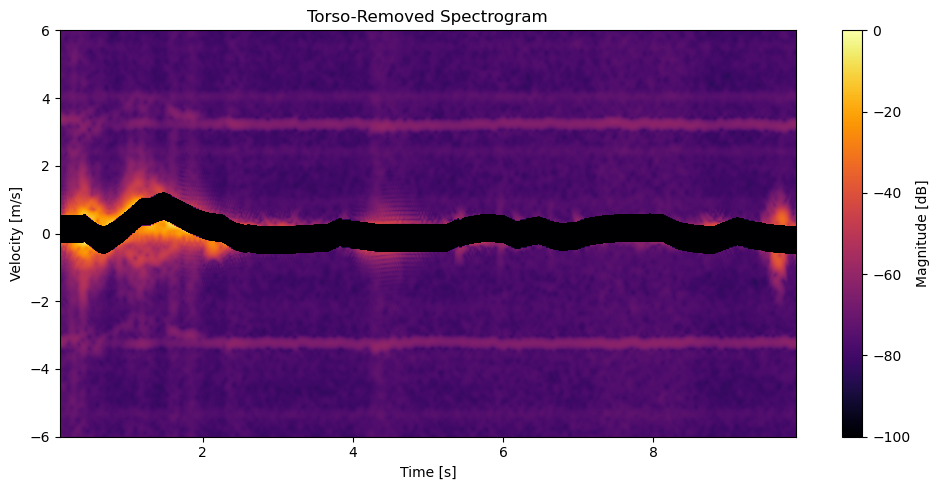

In [46]:
Sxx_torso_removed = remove_torso_from_spectrogram(Data_spec_MTI2, velocity_axis, kalman_torso_velocity)

plt.figure(figsize=(10, 5))
plt.imshow(20 * np.log10(Sxx_torso_removed + 1e-12), aspect='auto', origin='lower',
           extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]], cmap='inferno', vmin=-100, vmax=0)
plt.title('Torso-Removed Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(-6, 6)
plt.tight_layout()
plt.savefig('figures/torso_removed_spectrogram.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\3960233950.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  lower_envelope[i] = velocity_axis[above_thresh[0]]
C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\3960233950.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  upper_envelope[i] = velocity_axis[above_thresh[-1]]
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:767:

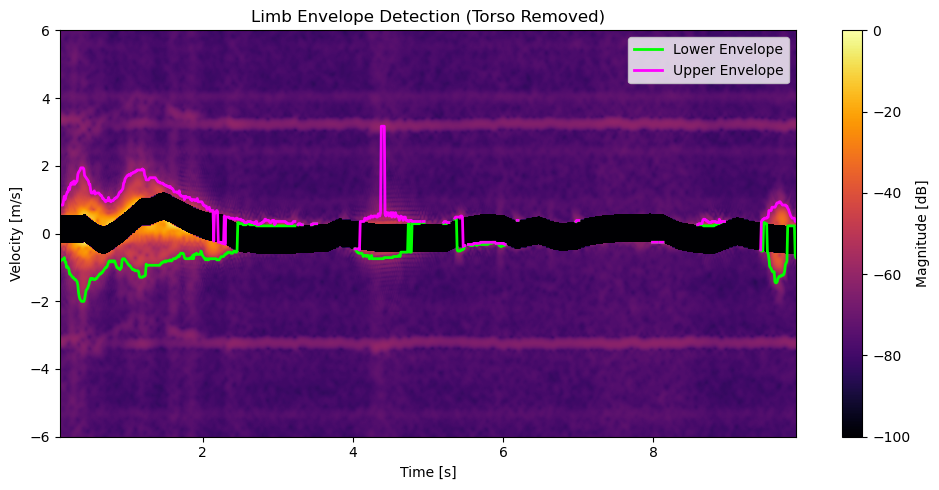

In [47]:
Sxx_dB = 20 * np.log10(Sxx_torso_removed + 1e-12)

noise_floor = np.percentile(Sxx_dB, 10)  # or use a patch in early time bins
threshold_dB = noise_floor + 20 # Set threshold above noise floor

lower_env, upper_env = detect_envelope(Sxx_dB, velocity_axis, threshold_dB)

plt.figure(figsize=(10, 5))
plt.imshow(Sxx_dB, aspect='auto', origin='lower',
           extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]],
           cmap='inferno', vmin=-100, vmax=0)
plt.plot(t, lower_env, color='lime', linewidth=2, label='Lower Envelope')
plt.plot(t, upper_env, color='magenta', linewidth=2, label='Upper Envelope')
plt.colorbar(label='Magnitude [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Limb Envelope Detection (Torso Removed)')
plt.legend()
plt.ylim(-6, 6)
plt.tight_layout()
plt.savefig('figures/torso_removed_spectrogram_with_envelope.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.show()

In [48]:
def remove_torso_from_spectrogram(Sxx, velocity_axis, torso_velocity_trace, bandwidth=0.4):
    """
    Removes the torso signature from the spectrogram and centers all motion around zero velocity
    for better limb motion analysis.
    
    Parameters:
    -----------
    Sxx : 2D array
        Input spectrogram
    velocity_axis : array
        Velocity axis values
    torso_velocity_trace : array
        Estimated torso velocity over time
    bandwidth : float
        Width of the suppression band around zero velocity in m/s
    
    Returns:
    --------
    Sxx_centered : 2D array
        Spectrogram with torso removed and motion centered around zero velocity
    """
    Sxx_centered = np.zeros_like(Sxx)
    zero_idx = np.argmin(np.abs(velocity_axis - 0))

    for i, torso_vel in enumerate(torso_velocity_trace):
        # Shift to center torso at 0
        shift_idx = np.argmin(np.abs(velocity_axis - torso_vel))
        shift_amount = zero_idx - shift_idx
        shifted_col = np.roll(Sxx[:, i], shift=shift_amount)

        # Apply suppression mask around 0 velocity
        suppress_mask = np.abs(velocity_axis) <= bandwidth
        shifted_col[suppress_mask] = 0

        # Store the centered version without rolling back
        Sxx_centered[:, i] = shifted_col

    return Sxx_centered

c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


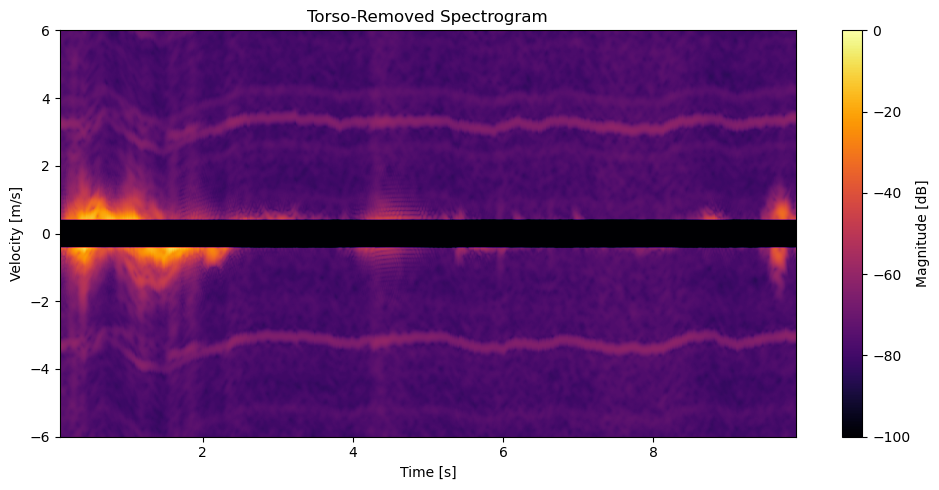

In [49]:
Sxx_torso_removed = remove_torso_from_spectrogram(Data_spec_MTI2, velocity_axis, kalman_torso_velocity)

plt.figure(figsize=(10, 5))
plt.imshow(20 * np.log10(Sxx_torso_removed + 1e-12), aspect='auto', origin='lower',
           extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]], cmap='inferno', vmin=-100, vmax=0)
plt.title('Torso-Removed Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.colorbar(label='Magnitude [dB]')
plt.ylim(-6, 6)
plt.tight_layout()
plt.savefig('figures/torso_removed_spectrogram_centered.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.show()

C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\3960233950.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  lower_envelope[i] = velocity_axis[above_thresh[0]]
C:\Users\Joost\AppData\Local\Temp\ipykernel_32024\3960233950.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  upper_envelope[i] = velocity_axis[above_thresh[-1]]
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\Joost\anaconda3\Lib\site-packages\matplotlib\transforms.py:767:

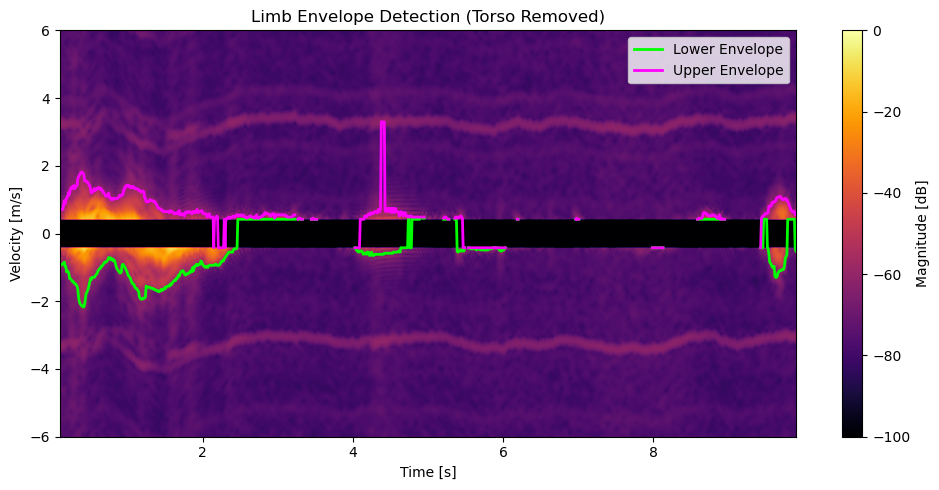

In [50]:
Sxx_dB = 20 * np.log10(Sxx_torso_removed + 1e-12)

noise_floor = np.percentile(Sxx_dB, 10)  # or use a patch in early time bins
threshold_dB = noise_floor + 20 # Set threshold above noise floor

lower_env, upper_env = detect_envelope(Sxx_dB, velocity_axis, threshold_dB)

plt.figure(figsize=(10, 5))
plt.imshow(Sxx_dB, aspect='auto', origin='lower',
           extent=[t[0], t[-1], velocity_axis[0], velocity_axis[-1]],
           cmap='inferno', vmin=-100, vmax=0)
plt.plot(t, lower_env, color='lime', linewidth=2, label='Lower Envelope')
plt.plot(t, upper_env, color='magenta', linewidth=2, label='Upper Envelope')
plt.colorbar(label='Magnitude [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Limb Envelope Detection (Torso Removed)')
plt.legend()
plt.ylim(-6, 6)
plt.tight_layout()
plt.savefig('figures/limb_envelope_detection.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()